********************************************************************          

SEASONALITY OF NEWSPAPER DATA AT THE WEEK LEVEL : EVIDENCES FROM THE GUARDIAN
 
********************************************************************

*Data used* : articles from the Guardian, during the first semester 2018, scraped with the API on the following link :

Due to Google colab RAM constraint, we were forced to limit our analysis to 6 months. 



*Research question*
The goal of our project is double. On the one hand, we want to focus on the specificity of the vocabulary used with respect to the category to which the article is labelled. Is the vocabulary used to tackle politic issues significantly different from the vocabulary used to talk about lifestyle questions ? We therefore want to establish the list of the words more frequently used for each category, and to determine differences. 

On the other hand, following Dzogang, Fabon; Lansdall-Welfare, Thomas; Cristianini, Nello (2017), Data from: Discovering periodic patterns in historical news, Dryad, Dataset, https://doi.org/10.5061/dryad.nh775, we would like to determine whether we can observe seasonal variations in the language used for each topic, even if our sample is much more reduced than the one used in the article. Since our sample contains data limited to a 6 month period, we are going to focus to the variations of textual data at the week level : can we predict the day of the week of publication based on the data ? Is there categories of article for which the day of publication is easier to predict ? 


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import xlrd
import seaborn as sns
import statsmodels.api as sm
from tqdm.notebook import tqdm
import re
import datetime


#Import of packages and functions for tokenization and lda
from nltk.tokenize import toktok 
import pdb # python debugger
from collections import Counter

from gensim.models import LdaModel
from gensim import corpora
import nltk
from string import punctuation
import pdb

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#Opening of google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# <font color="chillipepper"> I - Import of the data </font>

In [2]:
df = pd.read_json('/content/drive/MyDrive/NLP/2018.json')
print(["Number of rows", len(df)])

['Number of rows', 40550]


The dataset contains 40, 550 different articles. 

## Descriptive statistics at the articles' level

The articles of the Guardian are divided within 6 differents categories.

In [3]:
categories = list(df['pillarName'].unique())
categories

['News', 'Sport', 'Lifestyle', 'Opinion', 'Arts', None]

In [4]:
#Number of articles for each category
df.groupby(df.pillarName).size()


pillarName
Arts          7257
Lifestyle     3834
News         19361
Opinion       3473
Sport         6383
dtype: int64

In [5]:
#Removing of the articles with empty category
df = df[df["pillarName"].apply(lambda x: x in categories)]
df = df[df['pillarName'].isin(['News', 'Sport', 'Lifestyle', 'Opinion', 'Arts'])]
print(["Number of rows", len(df)])

['Number of rows', 40308]


The data set with pillarName (i.e labelled articles) contains  40, 308 articles.

In [6]:
df['fields'][0]

{'body': '<p>The Turnbull government is shifting itself on to a pre-election footing, declaring that next week’s budget will demonstrate the Coalition’s economic plan is working and also highlight the risks of a change to a Labor government.<br></p> <p>The treasurer, Scott Morrison, and the finance minister, Mathias Cormann, have emphasised that message before next week’s economic statement, which is expected to deliver income-tax cuts, a significant infrastructure spend, and investments in aged care and health, including a <a href="https://www.dailytelegraph.com.au/lifestyle/health/medicare-rebates-for-gps-to-rise-but-knee-mris-sleep-studies-and-back-surgery-restricted-in-budget/news-story/dc7896193fb3436c87bdd690f4fd0c4e">modest rise in the Medicare levy</a> for GP visits.</p> <p><a href="https://www.theguardian.com/info/2015/dec/08/daily-email-au">Sign up to receive the top stories in Australia every day at noon </a></p>  <figure class="element element-embed" data-alt="Sign up to re

In [7]:
#We want to restrict our analysis to few columns of the scraped dataset, and therefore exclude others. 
df = df[['fields','pillarName']]


In [8]:
#Creation of new variables to simplify the analysis

df['headline'] = df['fields'].apply(lambda x : x['headline'])
df['bodyText'] = df['fields'].apply(lambda x : x['bodyText'])
df['title_len'] = df.headline.apply(lambda x: len(x.split(' ')) )
df['content_len'] = df.bodyText.apply(lambda x: len(x.split(' ')) )

In [9]:
print(["Mean number of words by article " , np.mean(df["bodyText"].apply(lambda x : len(x)))])

categories = ['News', 'Sport', 'Opinion', 'Arts', 'Lifestyle']

liste_df= []
for category in categories:
  locals()["df_"+ str(category)] = df[df['pillarName'] == category]
  print(["Mean number of words for articles from "+str(category), np.mean(locals()["df_"+ str(category)].apply(lambda x : len(x)))])


['Mean number of words by article ', 4877.409596109954]
['Mean number of words for articles from News', 19361.0]
['Mean number of words for articles from Sport', 6383.0]
['Mean number of words for articles from Opinion', 3473.0]
['Mean number of words for articles from Arts', 7257.0]
['Mean number of words for articles from Lifestyle', 3834.0]


The shortest articles belong to the category Opinion, and the longest to th category News. 


# <font color="chillipepper"> II- Characterization of the words used with respect to the category and sequence classification </font>

### Counting of words

In [35]:
# Number of words in the articles content
arr_bodyText = df.bodyText.apply(lambda x: x.split(' ')).array
arr_bodyText = [ x for X in arr_bodyText for x in X]
print('%s "words" in the contents' % (len(set(arr_bodyText)) ) )

755388 "words" in the contents


In [36]:
# Number of words in the title content
arr_headline = df.headline.apply(lambda x: x.split(' ')).array
arr_headline = [ x for X in arr_headline for x in X]
print('%s "words" in the title contents' % (len(set(arr_headline)) ) )

60025 "words" in the title contents


### Tokenization at the word level

 Due to limited RAM, we can not test various tokenizers, and therefore choose the  tokenizer Toktok Tokenizer because of its generality. In the following cell, we also lower all the characters in the whole dataset, both for contents and headlines, and remove punctuation signs and stopwords.

In [14]:
#We want to remove the punctuation signs and the stopwords (set of articles that are not meaningful to analyze the text).
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

#supplementary is the list of characters that we need to exclude and is not included in the list punctuation
supplementary = ["’", "”" , "–" ]
to_be_removed = list(en_stop) + list(punctuation) + supplementary

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
tokenizer = toktok.ToktokTokenizer()


df['tokenized_headline'] = df.headline.apply(lambda x: tokenizer.tokenize(x.lower())).array
df['tokenized_bodyText'] = df.bodyText.apply(lambda x: tokenizer.tokenize(x.lower())).array

#We keep only rows with bodyText which are not empty (it corresponds to errors due to scrapping).
df = df[df["tokenized_bodyText"].map(lambda d: len(d)) > 0].reset_index()


for k in tqdm(range(0,len(df))) :
    df.tokenized_headline[k] = [x for x in df.tokenized_headline[k] if x not in to_be_removed]
    df.tokenized_bodyText[k] = [x for x in df.tokenized_bodyText[k] if x not in to_be_removed]

KeyboardInterrupt: ignored

### Words frequence with respect to the category

In [12]:
#Removing on articles with null pillarName
df = df[df["pillarName"].map(lambda d: len(d)) > 0]

In [13]:
#Creation of one dataframe for each category
liste_df= []
for category in categories:
  locals()["df_"+ str(category)] = df[df['pillarName'] == category]
  liste_df.append(locals()["df_"+ str(category)])

In [15]:
#Creation of a liste of most common words for each category
liste_count = []
for dataset in tqdm(liste_df):
  #words is the list of words by topics
  words = [x for X in dataset['tokenized_bodyText'] for x in X] 
  locals()["L_" + str(dataset)] = Counter(words).most_common()
  liste_count.append(locals()["L_" + str(dataset)])

  0%|          | 0/5 [00:00<?, ?it/s]

In [32]:
#Representation of most common words by category 
def representation_most_commmon(liste):
  mots_cles_news = {}
  for (i,j) in liste[:50] :
    mots_cles_news[i] = j

  figure = plt.figure(figsize = (15, 7))
  plt.bar(list(mots_cles_news.keys()), mots_cles_news.values(),orientation = 'vertical')
  plt.tick_params(axis = 'x', rotation = 90)
  plt.show()

for liste in liste_count:
    representation_most_commmon(liste)

### Topic modelling

We use a LDA model (Latent Dirichlet Allocation), which allows to extract and represent the topics contained in the articles. We choose to extract 3 topics because for num_topics ≽ 4, the topics are overlapping.

In [17]:
#preprocessing of the data to use LdaModel, and training of the model on the corpus
text_data = list(df['tokenized_bodyText'])
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
ldamodel = LdaModel(corpus, id2word=dictionary, num_topics=3)

In [ ]:
#installation and import of packages for representation of the LDA model
!pip install pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=08a3b7251b16185c5028c9e649d91a4912d1a570d6693a0da90c2f77edd08f83
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
lda_display = gensimvis.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


### TF-IDF : search engine

TF gives us information on how often a term appears in a document and its relative rarity in the collection of document
 

In [18]:
df['lowercontent'] = df.bodyText.apply(lambda x: x.lower(), 1)

In [19]:
df = df.reset_index()

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['lowercontent'])

query = df['lowercontent'][0] # on prend le contenu du premier article et on regarde les similarités avec les autres 
query_vec = vectorizer.transform([query])
results = cosine_similarity(X,query_vec)

In [49]:
from termcolor import colored

##### Search engine by topic

In [50]:
#Definition of the search engine function
def search_engine():
  query = input('Welcome to the search engine.\nEnter some keywords or type "exit" to stop the engine:')
  while query != "exit":
    query_vector = vectorizer.transform([query])
    results = cosine_similarity(X, query_vector)
    first_candidates = np.argsort(results.flatten())[-10:]
    first_candidates = np.flip(first_candidates, 0) 

#we print pillarName for the articles where the pillarName is non empty
    j = 0
    i = 0 
    while j < 5 :
      if len(df[df["index"] == first_candidates[i]]["pillarName"]) > 0:
        print(colored(df[df["index"] == first_candidates[i]]["pillarName"].values[0], 'cyan'))
        j = j + 1
      i = i + 1
    query = input('Enter some keywords:')

In [ ]:
search_engine()

Welcome to the search engine.
Enter some keywords or type "exit" to stop the engine:crisp
News
News
Arts
Sport
Arts
Enter some keywords:exit


Based on descriptive analysis of the frequence of words within each category of the paper, we can not observe meaningful results (in particular, for the categories Arts and Lifestyle, the most common words used are almost the same). Hence, we would like to use TF-IDF to extract the most important words for each category. 
Besides, our goal is to see if the keyword words by categories change over time. 

### TF-IDF : keyword extraction

To use TF-IDF as a keyword extraction method, but at a search engine method, we have to remove all the stopwords, the punctuation signs, and the stopwords. 

We would like to keep as the test sample few articles for each category, and then see to what extent the keywords are distinct with respect to the considered category. We hope to recreate graphs like in the section 'Words frequence with respect to the category' that are more meaningful than the only frequence graph. 


There is 3,432 articles among the Opinion category (which is the minimum of number for categories), therefore we decided to keep approximately 10% of the articles of each category. We keep therefore 300 articles in the test sample for each category. 
For each article, we extract 50 keywords. 

In [20]:
#definition of a function
def preprocess_raw_text(x):
  querywords = x.split()
  resultwords  = [word for word in querywords if word not in to_be_removed]
  result = ' '.join(resultwords)
  return(result)

In [23]:
df['lowercontent'] = df['lowercontent'].apply(preprocess_raw_text)

In [19]:
#Definition of the functions to extract keywords (the code comes from the Kaggle tutorial keyword extraction using TF-IDF method, https://www.kaggle.com/code/rowhitswami/keywords-extraction-using-tf-idf-method/notebook)

TOP_K_KEYWORDS = 50

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature, score
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results


def get_keywords(vectorizer, feature_names, doc):
    """Return top k keywords from a doc using TF-IDF method"""

    #generate tf-idf for the given document
    tf_idf_vector = vectorizer.transform([doc])
    

      #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only TOP_K_KEYWORDS
    keywords=extract_topn_from_vector(feature_names,sorted_items,TOP_K_KEYWORDS)
    
    return list(keywords.keys())

In [21]:
#Creation of a test and a train set
import random 

restrained = df[df.index == 0]
for category in tqdm(categories):
  index = random.sample(list(df[df["pillarName"] == category]["index"]), 150)
  datatest = df[df["index"].apply( lambda x: x not in index)]
  restrained = pd.concat([restrained, df[df["index"].apply( lambda x: x in index)]])

restrained = restrained[1::]

  0%|          | 0/5 [00:00<?, ?it/s]

In [26]:
corpora = datatest["lowercontent"].to_list()
vectorizer.fit_transform(corpora)
feature_names = vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
restrained = restrained.reset_index(drop = True)

In [33]:
result = []
i = 0 
for doc in restrained["lowercontent"].to_list():
  dataf = {}
  dataf['full_text'] = doc
  dataf['top_keywords'] = get_keywords(vectorizer, feature_names, doc)
  dataf['pillarname'] = restrained["pillarName"][i]
  result.append(dataf)
  i = i+ 1
    
final = pd.DataFrame(result)

In [34]:
import itertools

liste_count_tf_idf = []
for categ in tqdm(categories):
  #words is the list of words by topics
  words =  list(itertools.chain.from_iterable(final[final["pillarname"] == categ]["top_keywords"].values))
  locals()["L_" + str(categ)+ "tf_idf"] = Counter(words).most_common()
  liste_count_tf_idf.append(locals()["L_" + str(categ)+ "tf_idf"])

  0%|          | 0/5 [00:00<?, ?it/s]

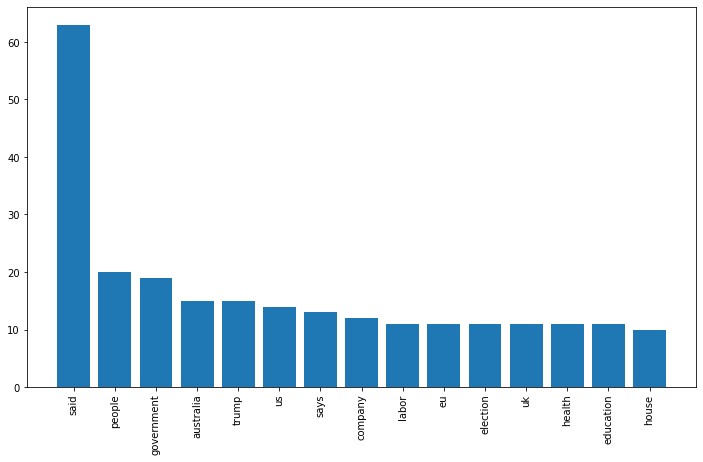

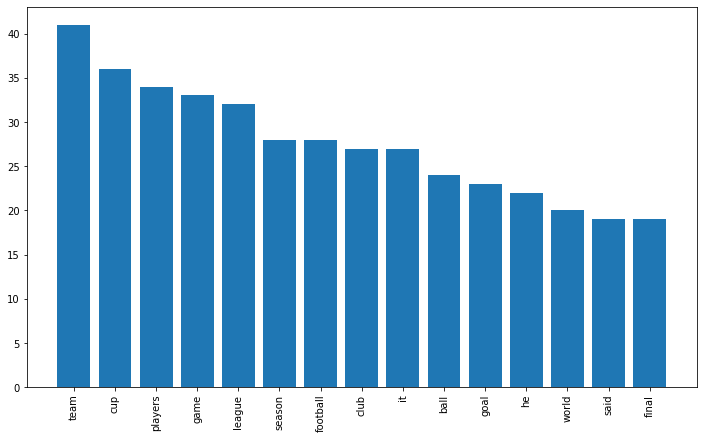

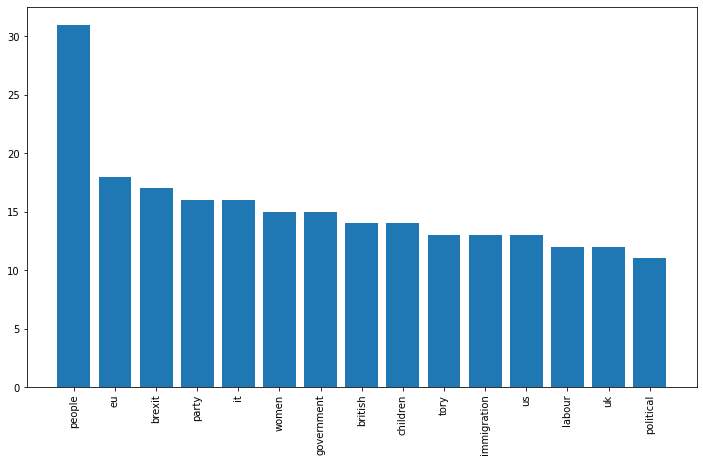

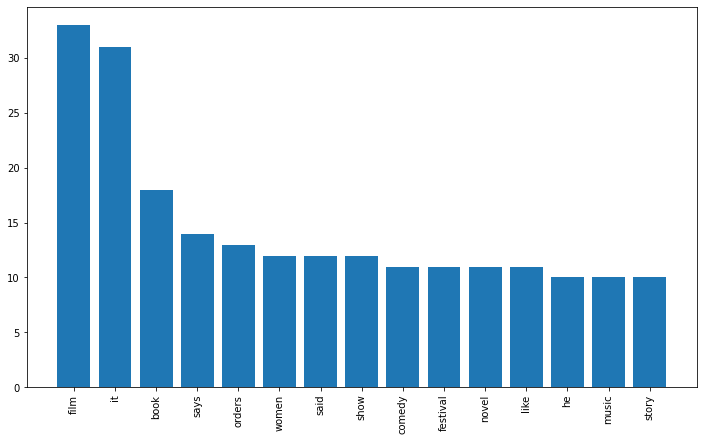

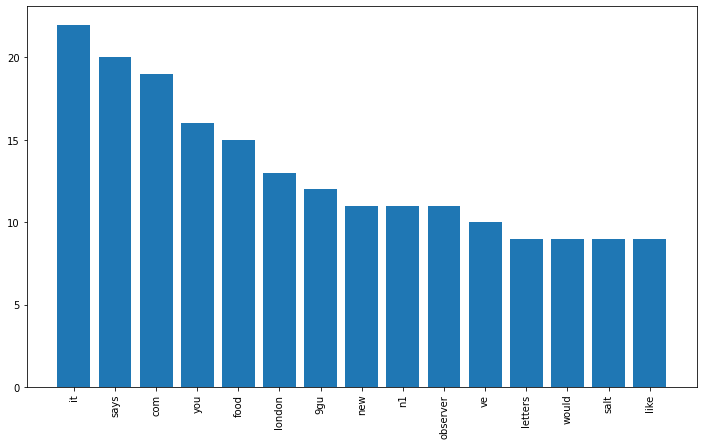

In [35]:
def representation_most_commmon(liste):
  mots_cles_news = {}
  for (i,j) in liste[:15] :
    mots_cles_news[i] = j

  figure = plt.figure(figsize = (12, 7))
  plt.bar(list(mots_cles_news.keys()), mots_cles_news.values(),orientation = 'vertical')
  plt.tick_params(axis = 'x', rotation = 90)
  plt.show()

for liste in liste_count_tf_idf:
  representation_most_commmon(liste)

Thanks to the tf-idf method, we have been able to extract meaningful important words for each category. 

In [36]:
df.to_json('/content/drive/MyDrive/NLP/2018tokenized.json')


# <font color="chillipepper"> III - Seasonality of words and vocabulary </font>

Our original research question was the study of the evolution of the vocabulary used over time. Due to limited RAM constraint, we were not able the data originally scraped (from 2008 to 2018). We choose to focus on the biggest sample we were able to deal with, i.e 6 months and to study the first 6 months of the year 2018. 

In [5]:
#Re import of the database because of RAM constraint
df = pd.read_json('/content/drive/MyDrive/NLP/2018tokenized.json')
categories = pd.unique(df["pillarName"])

In [22]:
#For dictionnary with no key for the date, we add the date 0 
for i in tqdm(range(0, len(df))):
  if df["fields"][i].get('firstPublicationDate', None) == None:
    df["fields"][i]['firstPublicationDate'] = "0"

  0%|          | 0/39494 [00:00<?, ?it/s]

KeyError: ignored

## 1) Descriptive statistics 

In [23]:
df["date"] = df["fields"].apply(lambda x: x["firstPublicationDate"])
print(["Number of articles", len(df)])

df = df[df["date"] != "0"]
print(["Number of articles with a date", len(df)])

df = df [df["date"].apply(lambda x: x[0:4] == "2018")]
print(["Number of articles on the right sample", len(df)])

['Number of articles', 39494]
['Number of articles with a date', 39494]
['Number of articles on the right sample', 39494]


In [24]:
#conversion of the date into date data
df["date"] = df["date"].apply(lambda x: x[0:10],"%Y-%m-%d")
df["date"] = pd.to_datetime(df["date"])

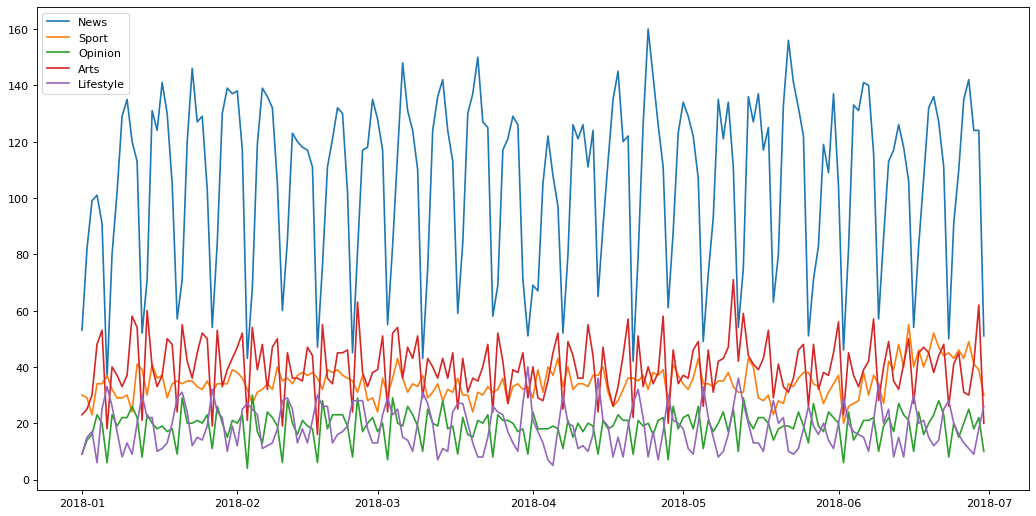

In [25]:
plt.figure(figsize=(16, 8), dpi=80)

for i in range(0, len(categories)):
  cat = categories[i]
  plt.plot(df[df["pillarName"] == cat].groupby(['date']).count()["index"], label = cat)
plt.legend()
plt.show()


We observe that all the series present a seasonnality at the week scale. Indeed, the number of articles published for each category is very stable for a given day of the week.

Using the same technique than when we study the differences of vocabulary between categories. 

In [26]:
df["day" ] = df["date"].apply(lambda x : x.weekday())
pd.unique(df["day"])

array([4, 3, 1, 0, 2, 6, 5])

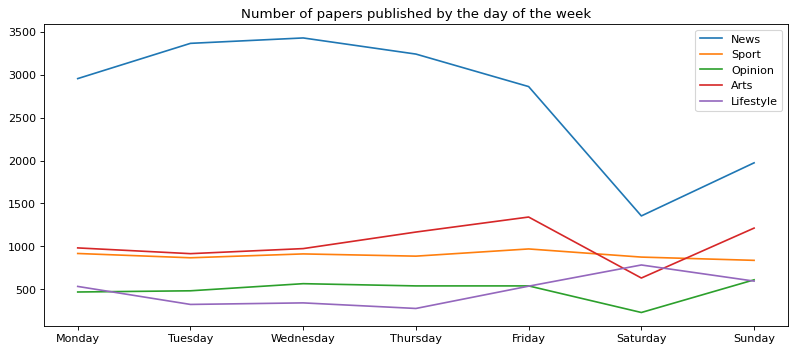

In [27]:
plt.figure(figsize=(12, 5), dpi=80)

for i in range(len(categories)):
  cat = categories[i]
  plt.plot(df[df["pillarName"] == cat].groupby(['day']).count()["index"], label = cat)
plt.title("Number of papers published by the day of the week")
plt.xticks( range(0,7),labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.legend()
plt.show()


### Description of the evolution of the vocabulary used with TF-IDF

In [28]:
liste_day = pd.unique(df["day"])

#Creation of a test and a train set
import random 

restrained = df[df.index == 0]
for day in tqdm(liste_day):
  index = random.sample(list(df[df["day"] == day]["index"]), 150)
  datat = df[df["index"].apply( lambda x: x not in index)]
  restrained = pd.concat([restrained, df[df["index"].apply( lambda x: x in index)]])

restrained = restrained[1::]

  0%|          | 0/7 [00:00<?, ?it/s]

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()

corpora = datat["lowercontent"].to_list()
vectorizer.fit_transform(corpora)
feature_names = vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


  0%|          | 0/7 [00:00<?, ?it/s]

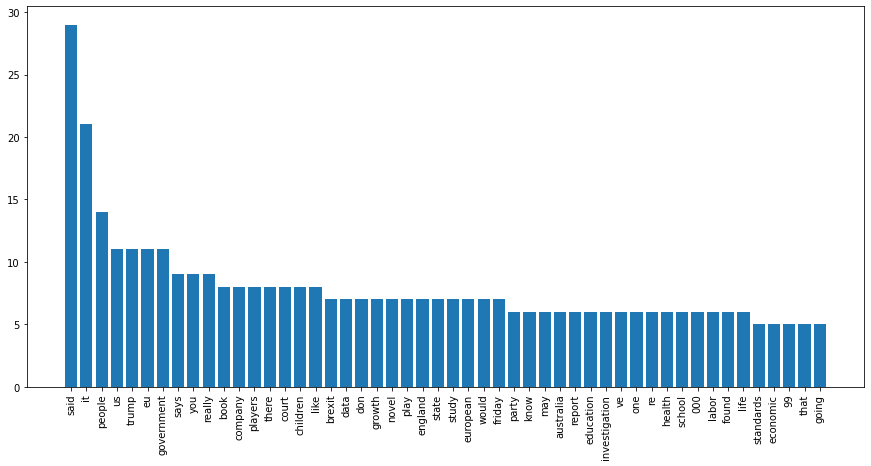

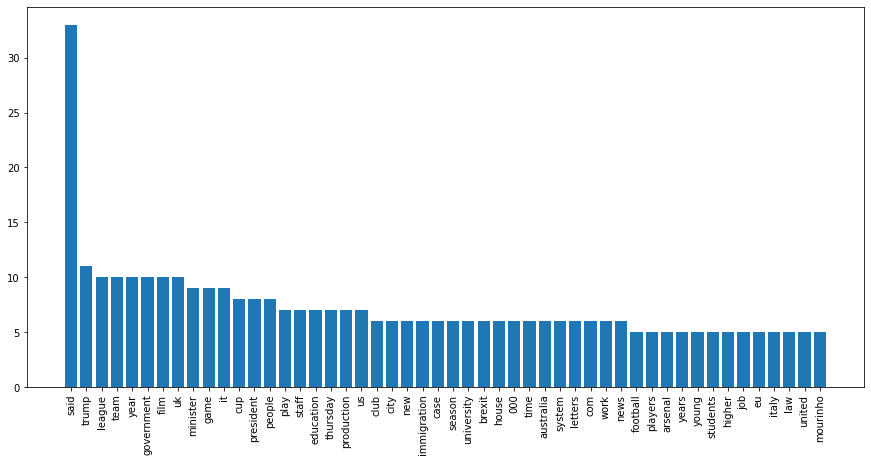

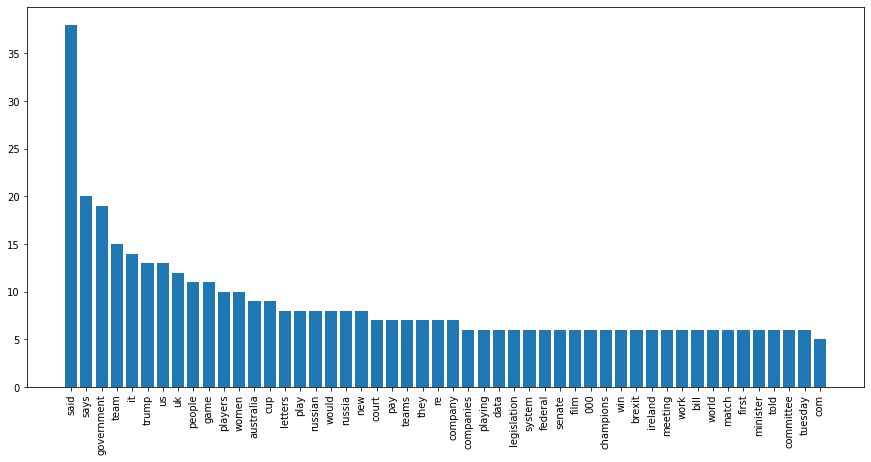

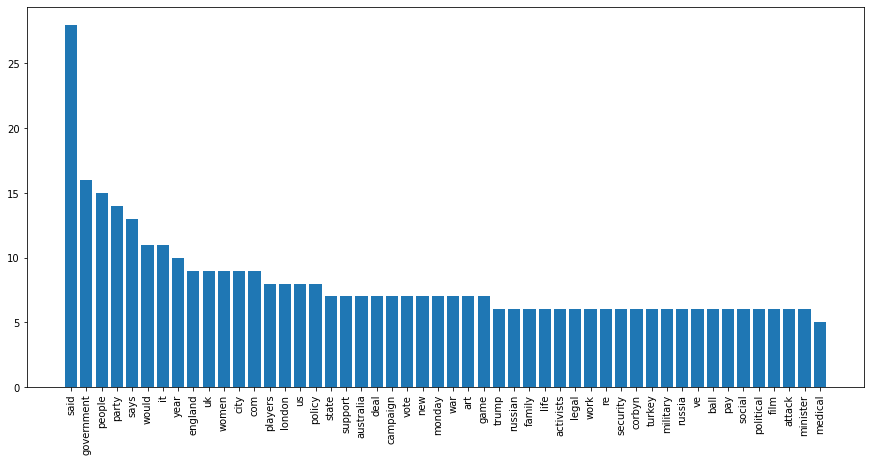

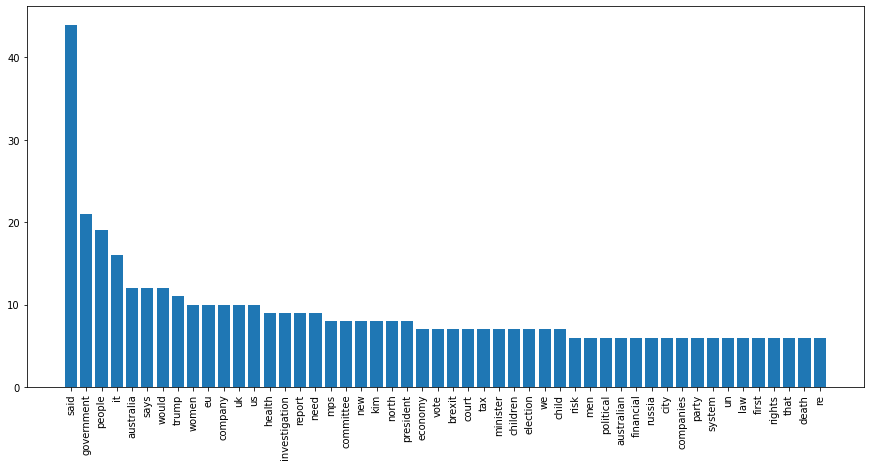

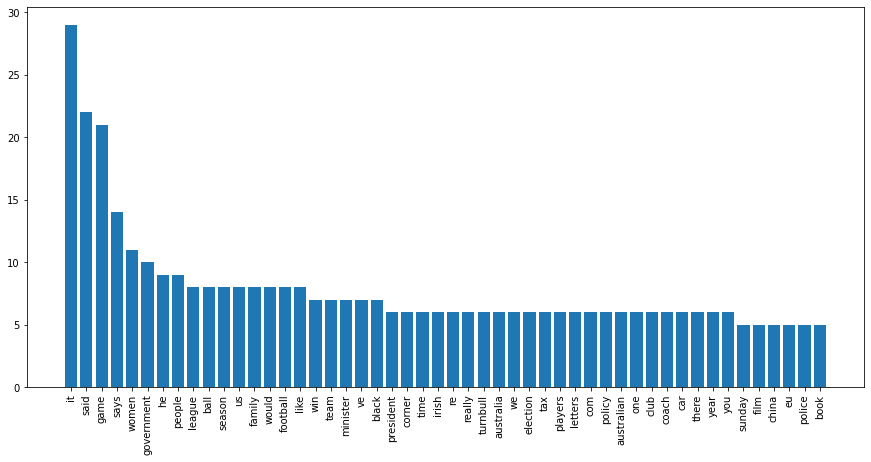

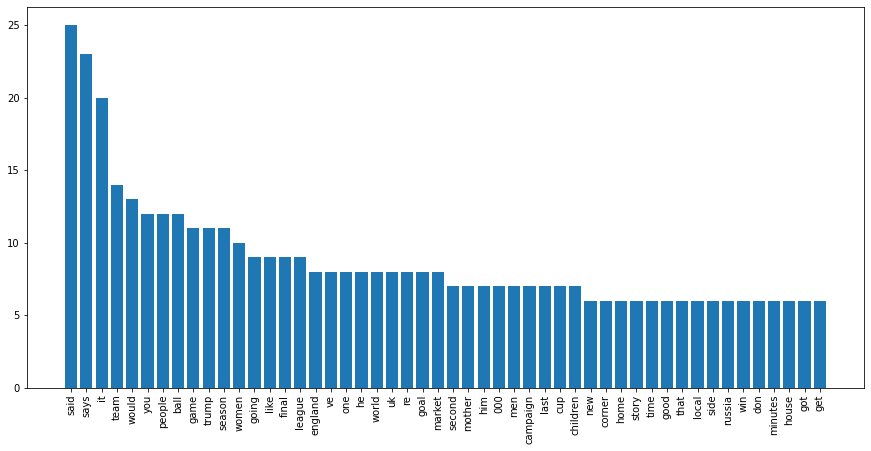

In [33]:
restrained = restrained.reset_index(drop = True)
result = []
i = 0 
for doc in restrained["lowercontent"].to_list():
  dataf = {}
  dataf['full_text'] = doc
  dataf['top_keywords'] = get_keywords(vectorizer, feature_names, doc)
  dataf['day'] = restrained["day"][i]
  result.append(dataf)
  i = i+ 1
    
final = pd.DataFrame(result)


import itertools

liste_count_tf_idf = []
for categ in tqdm(liste_day):
  #words is the list of words by topics
  words =  list(itertools.chain.from_iterable(final[final["day"] == categ]["top_keywords"].values))
  locals()["L_" + str(categ)+ "tf_idf"] = Counter(words).most_common()
  liste_count_tf_idf.append(locals()["L_" + str(categ)+ "tf_idf"])


for liste in liste_count_tf_idf:
  representation_most_commmon(liste)

Because we notice in the first part that the counting of words was not very relevant to distinguish which words were the most important for each category, we decide to proceed in the same way than what we have done in the part II to descript the vocabulary used. We do not notice tremendous differences between each day of the week. Yet, we remark that word "Tuesday" is extracted as keyword only in papers published on Wednesday, and that words related to sport are more present in the weekend. 

## 2) Prediction part

### A - Baseline model 

Our first strategy is to try to predict the week of publication based on tf-idf techniques, and then to predict thanks to a multinomial logistic regression.

Our test set is the same as defined in the part 1), called restrained, and our train test is called corpora. 

We lemmatize our sample using the WordNetLemmatizer.

In [34]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
corpora = [" ".join([lemmatizer.lemmatize(word) for word in corpora[i].split()]) for i in tqdm(range(0, len(corpora)))]

  0%|          | 0/39344 [00:00<?, ?it/s]

In [67]:
X_train_tf = vectorizer.fit_transform(corpora)
X_train_tf = vectorizer.transform(corpora)

In [70]:
restrained["lowercontent"] = [" ".join([lemmatizer.lemmatize(word) for word in restrained["lowercontent"][i].split()]) for i in tqdm(range(0, len(restrained)))]

  0%|          | 0/1050 [00:00<?, ?it/s]

In [72]:
X_test_tf = vectorizer.transform(restrained["lowercontent"])

In [88]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

model = MultinomialNB()
model.fit(X_train_tf, datat["day"])

MultinomialNB()

In [90]:
y_pred = model.predict(X_test_tf)
print(metrics.classification_report(restrained["day"], y_pred, target_names=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']))

              precision    recall  f1-score   support

      Monday       0.62      0.13      0.22       150
     Tuesday       0.59      0.47      0.52       150
   Wednesday       0.31      0.71      0.43       150
    Thursday       0.54      0.42      0.47       150
      Friday       0.27      0.70      0.38       150
    Saturday       1.00      0.02      0.04       150
      Sunday       0.76      0.19      0.31       150

    accuracy                           0.38      1050
   macro avg       0.59      0.38      0.34      1050
weighted avg       0.59      0.38      0.34      1050



## B) Classification model using Pytorch

In [97]:
import torch
from torch.utils.data import Dataset
import numpy as np

class paperDataset(Dataset):
    def __init__(self, data, args):
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          "label": np.array(self.data[idx]['label'])
      }
      return item

In [98]:
from torch.utils.data import DataLoader
args = {'bsize': 64}
train_loader = DataLoader(paperDataset(corpora, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
val_loader   = DataLoader(paperDataset(corpora, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
test_loader  = DataLoader(paperDataset(restrained["lowercontent"], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [99]:
class MinimalExampleModel(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(MinimalExampleModel, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H, bias=True)
        # define the final linear layer, often named classification layer as the output dimension (D_out) == the number of target classes
        self.linear2 = torch.nn.Linear(H, D_out, bias=True)

    def forward(self, x):
        h_relu = torch.relu(self.linear1(x))
        y_pred = self.linear2(h_relu)
        return y_pred

N, D_in, H, D_out = 2, 10, 10, 2 
model = MinimalExampleModel(D_in, H, D_out)

## C) Classification model + BERT

# Conclusion